In [1]:
# Numerical/Stats pack
import numpy as np
from collections import Counter
from collections import defaultdict
import math
import numpy.linalg as nl
from cvxopt import matrix, solvers
import itertools
import scipy.linalg as sl

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from qiskit.visualization import plot_histogram
plt.rcParams["figure.dpi"] = 150

In [2]:
def get_basis(num_qubits, index):
    """
    Parameters
    ----------
    num_qubits : int
        number of qubits.
    index : int
        Which qubit is 1. Order follows measurement order

    Returns
    -------
    base : int
        the basis string where target position is 1
        e.g., num_qubits=5, index=1, then return '01000'

    """
    origin = list('0'*num_qubits)
    origin[index] = '1'
    return ''.join(origin)
    
def qubit_matrix(p0m0,p1m1):
    """
    Parameters
    ----------
    p0m0 : ndarray(dtype=np.float64, dim=num_qubits)
        Pr(0|0) for all qubits
    p1m1 : ndarray(dtype=np.float64, dim=num_qubits)
        Pr(1|1) for all qubits

    Returns
    -------
    mats: np.array(dim=num_qubits*2*2)
        mats[i] is 2-by-2 measurement error transition matrix for ith qubit
    """
    num_qubits = p0m0.shape[0]
    mats = np.zeros((num_qubits,2,2), dtype=np.float64)
    for i in range(num_qubits):
        mats[i] = np.array([[p0m0[i], 1-p1m1[i]],[1-p0m0[i], p1m1[i]]])
        
    return mats

def dictToVec(nQubits, counts):
    """ Transfer counts to probabilities

    Args:
      nQUbits: int
        number of qubits
      counts: dict
        an dictionary in the form {basis string: frequency}. E.g.
        {"01": 100
         "11": 100}
        dict key follow little-endian convention

    Returns: numpy array
      an integer vector (array). E.g.
      [0, 100, 0, 100] is the result from example above.
    """
    vec = np.zeros(2**nQubits)
    form = "{0:0" + str(nQubits) + "b}"
    for i in range(2**nQubits):
        key = form.format(i) # consider key = format(i,'0{}b'.format(nQubits))
                             # and delete variable form
        if key in counts.keys():
            vec[i] = int(counts[key])
        else:
            vec[i] = 0
    return vec


def print_info(mat):
    u, s, vh = np.linalg.svd(mean_mat-mat, full_matrices=True)
    ns = np.sum(s<1e-3)
    print("Rank={:.4g} # singular value < 1e-3={:.4g}".format(np.linalg.matrix_rank(mat),ns))
    print("Inf norm={:.4g}, Frobenius norm={:.4g}, 2-Norm={:.4g}".format(np.linalg.norm(mat, ord=np.inf), 
                                                                              np.linalg.norm(mat, ord='fro'),
                                                                              np.linalg.norm(mat, ord=2)))
    print("Among {:d} entries, {:d} entries < 1e-3, {:d} entries < 1e-4, {:d} entries < 1e-6".format(mat.shape[0]*mat.shape[1],
                                                                                                      mat[np.abs(mat)<1e-3].shape[0],
                                                                                                      mat[np.abs(mat)<1e-4].shape[0], 
                                                                                                      mat[np.abs(mat)<1e-6].shape[0]))
    
    
def extract_qubits(s, pos, correct_rest_bits):
    # Extract elements in given positions
    # E.g., s = '11010', pos = [0,2,3], correct_rest_bits = '10', the func returns 0, '101'
    # E.g., s = '11011', pos = [0,2,3], correct_rest_bits = '10', the func returns 1, '101'
    # E.g., s = '10011', pos = [0,2,3], correct_rest_bits = '10', the func returns 2, '101'
    # Because one of the unselected qubits (the last one) is different from correct_rest_bits
    res = []
    cor_count = 0
    total_num_qubits = len(pos)+len(correct_rest_bits)
    correct_rest_list = list(correct_rest_bits)
    for i in range(total_num_qubits):
        if i in pos:
            res.append(s[i])
        else:
            if s[i] != correct_rest_list.pop(0):
                cor_count += 1
    return cor_count, ''.join(res)

def recover_basis(target_basis, pos, rest_bits):
    # E.g., i = 3 (corresponds to '011'), pos = [0,2,3], rest_bits = '01'
    # func returns '0(0)11(1)'(no brackets) where two bits 0 and 1 in () corresponds to qubit 1 and 4
    total_num_qubits = len(pos)+len(rest_bits)
    selected_bits = list(target_basis)
    rest_bits_list = list(rest_bits)
    res = []
    for i in range(total_num_qubits):
        if i in pos:
            res.append(selected_bits.pop(0))
        else:
            res.append(rest_bits_list.pop(0))
    return ''.join(res)

    
def read_string_data(target_basis, selected_qubits, total_qubits, file_address, file_name=''):
    #target_basis corresponds to selected_qubits, instead of all qubits
    unselected_num_qubits = total_qubits - len(selected_qubits)
    if unselected_num_qubits == 0:
        if len(file_name) > 0:
            return np.genfromtxt(file_address + file_name, delimiter=',',dtype=np.str)
        return np.genfromtxt(file_address + 'Basis'+target_basis+'.csv', delimiter=',',dtype=np.str)
    else:
        orgin_data = np.array([],dtype=np.str)
        selected_data = np.array([],dtype=np.str)
        unselected_data = np.array([],dtype=np.str)
#         for bn in range(2**unselected_num_qubits):
#         rest_bits = format(bn, "0{:d}b".format(unselected_num_qubits)) # Only look at the case when the rest qubits are 0
        rest_bits = format(0, "0{:d}b".format(unselected_num_qubits))
        full_basis = recover_basis(target_basis, selected_qubits, rest_bits) # basis that length num_qubits 
                                                                  # where the selected indices corresponds to target_basis
        print(target_basis, '->', full_basis)
        if len(file_name) > 0:
            orgin_data = np.genfromtxt(file_address + file_name, delimiter=',',dtype=np.str)
#                 origin_data = np.append(orgin_data, np.genfromtxt(file_address + file_name, delimiter=',',dtype=np.str))
        else:
            orgin_data = np.genfromtxt(file_address + 'Basis'+full_basis+'.csv', delimiter=',',dtype=np.str)
#                 origin_data = np.append(orgin_data, np.genfromtxt(file_address + 'Basis'+full_basis+'.csv', delimiter=',',dtype=np.str))
        # Select out all uncorrelated bits
        for s in orgin_data:
            corr_count, new_s = extract_qubits(s, selected_qubits, rest_bits)
            if corr_count == 0:
                selected_data = np.append(selected_data, new_s)
            else:
                unselected_data = np.append(unselected_data, new_s)
    return selected_data

def neg_off_diag(G):
    res = np.copy(G)
    nrow, ncol = G.shape
    for i in range(nrow):
        for j in range(ncol):
            if i != j and G[i,j] < 0:
                res[i,j] = 0
    return res

In [3]:
# Cite https://www.geeksforgeeks.org/check-whether-two-numbers-differ-one-bit-position/
  
# function to check if x is power of 2 
def isPowerOfTwo( x ): 
  
    # First x in the below expression is 
    # for the case when x is 0 
    return x and (not(x & (x - 1))) 
  
# function to check whether the two numbers 
# differ at one bit position only 
def differAtOneBitPos( a , b ): 
    return isPowerOfTwo(a ^ b) 
 
# Function to find the position of 
# rightmost set bit in 'n'
def getRightMostSetBit(n):
    if (n == 0):
        return 0
 
    return math.log2(n & -n)
 
# Cite https://www.geeksforgeeks.org/position-rightmost-different-bit/
# Function to find the position of 
# rightmost different bit in the 
# binary representations of 'm' and 'n'
def posOfRightMostDiffBit(m, n):
 
    # position of rightmost different
    # bit
    return int(getRightMostSetBit(m ^ n))

In [4]:
# Choose machine
# file_address = "./QuitoData/" # Both machine has 5 qubits
# file_address = "./LimaData/" # Both machine has 5 qubits
file_address = './BelemData/'
total_qubits = 5
selected_qubits = [0,1,2,3,4] # Measurement order
num_qubits = len(selected_qubits)

np.random.seed(127)
coor_intv = 1 if num_qubits < 5 else 2 # Inverval for xlabel and ylabel

In [5]:
# Full Matrix
mean_mat = np.zeros((2**num_qubits,2**num_qubits))
for bn in range(2**num_qubits):
    target = format(bn, "0{:d}b".format(num_qubits))
    string_data = read_string_data(target, selected_qubits, total_qubits, file_address)
    mean_mat[:,int(target,2)] = dictToVec(num_qubits,dict(Counter(string_data)))/string_data.shape[0]

In [6]:
qubits_pairs = list(itertools.combinations(selected_qubits, 2))
print("Qubit pairs:", qubits_pairs)


# Compute Error Rates
r01 = np.zeros(num_qubits, dtype=np.float64) # Save all r^{0->1}
r10 = np.zeros(num_qubits, dtype=np.float64) # Save all r^{1->0}
CTMPerr_rates = defaultdict(dict) # record two-qubits error rates using CTMPerr_rates[qubit_pair][ideal_double_bits]
for selected_pair in qubits_pairs:#(j,k)
    print(selected_pair)
    x_out = '0'*(total_qubits-2)
    Ajk = np.zeros((4,4), dtype=np.float64)
    for i in range(4):
        x_in = format(i, "0{:d}b".format(2))
        string_data = read_string_data(x_in, selected_pair , total_qubits, file_address) # Use selected_pair instead of selected qubits
        counts = Counter(string_data)
        Ajk[:,i] = (dictToVec(2, counts)/sum(counts.values()))
    # Compute G(j,k) and G'(j,k)
    Gjk = sl.logm(Ajk) # G(j,k)
    Gpjk = neg_off_diag(Gjk) # G'(j,k)
    # Record CTMP Error Rates
    # Single Qubit
    r01[selected_qubits.index(selected_pair[0])] += (Gpjk[2,0]+Gpjk[3,1]) # <10|G'(j,k)|00>+<11|G'(j,k)|01>
    r10[selected_qubits.index(selected_pair[0])] += (Gpjk[0,2]+Gpjk[1,3]) # <00|G'(j,k)|10>+<01|G'(j,k)|11>
    r01[selected_qubits.index(selected_pair[1])] += (Gpjk[1,0]+Gpjk[3,2]) # <01|G'(j,k)|00>+<11|G'(j,k)|10>
    r10[selected_qubits.index(selected_pair[1])] += (Gpjk[0,1]+Gpjk[2,3]) # <00|G'(j,k)|01>+<10|G'(j,k)|11>
    CTMPerr_rates[selected_pair]['00'] = Gpjk[3,0] # <11|G'(j,k)|00> 00->11
    CTMPerr_rates[selected_pair]['01'] = Gpjk[2,1] # <10|G'(j,k)|01> 01->10
    CTMPerr_rates[selected_pair]['10'] = Gpjk[1,2] # <01|G'(j,k)|10> 10->01
    CTMPerr_rates[selected_pair]['11'] = Gpjk[0,3] # <00|G'(j,k)|11> 11->00
    
r01 = r01/(2*(num_qubits - 1)) # Normalize with 1/(2(2n-1))
r10 = r10/(2*(num_qubits - 1))

Qubit pairs: [(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
(0, 1)
00 -> 00000
01 -> 01000
10 -> 10000
11 -> 11000
(0, 2)
00 -> 00000
01 -> 00100
10 -> 10000
11 -> 10100
(0, 3)
00 -> 00000
01 -> 00010
10 -> 10000
11 -> 10010
(0, 4)
00 -> 00000
01 -> 00001
10 -> 10000
11 -> 10001
(1, 2)
00 -> 00000
01 -> 00100
10 -> 01000
11 -> 01100
(1, 3)
00 -> 00000
01 -> 00010
10 -> 01000
11 -> 01010
(1, 4)
00 -> 00000
01 -> 00001
10 -> 01000
11 -> 01001
(2, 3)
00 -> 00000
01 -> 00010
10 -> 00100
11 -> 00110
(2, 4)
00 -> 00000
01 -> 00001
10 -> 00100
11 -> 00101
(3, 4)
00 -> 00000
01 -> 00001
10 -> 00010
11 -> 00011


In [7]:
r01,r10,CTMPerr_rates

(array([0.00715596, 0.00517586, 0.00947147, 0.0120173 , 0.02710411]),
 array([0.04122751, 0.04971813, 0.05392737, 0.06221985, 0.06623906]),
 defaultdict(dict,
             {(0, 1): {'00': 5.51002953875189e-06,
               '01': 6.105804005530988e-05,
               '10': 0.00011051930071618449,
               '11': 2.9903905544722068e-05},
              (0, 2): {'00': 1.6844469975041756e-05,
               '01': 0.0,
               '10': 4.7405070393751955e-05,
               '11': 4.83546289401296e-06},
              (0, 3): {'00': 0.0,
               '01': 7.86585280959963e-05,
               '10': 0.00018570134578875432,
               '11': 0.0},
              (0, 4): {'00': 0.00010898468457487889,
               '01': 0.0,
               '10': 0.0,
               '11': 0.0},
              (1, 2): {'00': 3.337435912583765e-06,
               '01': 0.0,
               '10': 0.0,
               '11': 1.3759857775744871e-05},
              (1, 3): {'00': 0.00010617706163118176,
   

In [8]:
def tensor_I_around(center_mat, nBefore, nAfter):
    # Compute Kronecker product I \otimes ... I \otimes center_mat \otimes I \otimes ... \otimes I
    # The are nBefore number of I before center_mat and nAfter number of I after center_mat
    if nBefore >= 1:
        res = np.identity(2)
        for _ in range(nBefore - 1):
            res = np.kron(res, np.identity(2))
        res = np.kron(res, center_mat)
    else:
        res = center_mat
    for _ in range(nAfter):
        res = np.kron(res, np.identity(2))
    return res
        

In [9]:
def map_bits(s, order1, order2):
    # Shift the bits in s from order1 to order 2
    res = list(s)
    for o in order1:
        res[order2.index(o)] = s[order1.index(o)]
    return ''.join(res)
        

In [10]:
def map_entries(A, order1, order2):
    # Entris of A is based on order1, e.g, [Qubiut 4, Qubit 2, Qubit3] (just input [4,2,3] or a tuple)
    # And you want to get a matrix based on order2, .e.g., [Qubit 2, Qubit 3, Qubit4] (just input [2,3,4] or a tuple)
    # This function will do this for you
    # Assume A is numpy array
    res = np.zeros(A.shape, dtype=np.float64)
    nrows, ncols = A.shape
    bit_length = len(order1)
    for i in range(nrows):
        for j in range(ncols):
            bits_i =  format(i, "0{:d}b".format(bit_length))
            bits_j =  format(j, "0{:d}b".format(bit_length))
            mapped_i = map_bits(bits_i, order1, order2)
            mapped_j = map_bits(bits_j, order1, order2)
            res[int(mapped_i,2), int(mapped_j,2)] = A[i,j]
    return res
    

In [11]:
G = np.zeros((2**num_qubits,2**num_qubits), dtype=np.float64)

ket0 = np.array([1,0]).reshape((2,1))
ket1 = np.array([0,1]).reshape((2,1))
ket00 = np.array([1,0,0,0]).reshape((4,1))
ket01 = np.array([0,1,0,0]).reshape((4,1))
ket10 = np.array([0,0,1,0]).reshape((4,1))
ket11 = np.array([0,0,0,1]).reshape((4,1))
## Compute Generators
# 1 Qubit
G01 = np.dot(ket1,ket0.T) - np.dot(ket0,ket0.T)
G10 = np.dot(ket0,ket1.T) - np.dot(ket1,ket1.T)
for i in range(num_qubits):
    # Tensor identity to generator to reach full space
    G += r01[i]*tensor_I_around(G01, i, num_qubits-i-1)+r10[i]*tensor_I_around(G10, i, num_qubits-i-1)
    
# 2 Qubit
G0110 = ket10.dot(ket01.T)-ket01.dot(ket01.T)
G1001 = ket01.dot(ket10.T)-ket10.dot(ket10.T)
G0011 = ket11.dot(ket00.T)-ket00.dot(ket00.T)
G1100 = ket00.dot(ket11.T)-ket11.dot(ket11.T)
for pair in qubits_pairs:
    x,y = pair # Qubit x, Qubit y
    # Make sure x < y
    if x>y:
        temp = x
        x = y
        y = temp
    # If Qubits are next to each other
    if abs(x-y) == 1:
        # Tensor identity to generator to reach full space
        # E.g. x,y = (2,3) and selected_qubits are [2,3,4], then need to tensor 1 identity matrix at the end
        # x,y = (2,3) and selected_qubits are [0,1,2,3,4], then tensor 2 identity at the front and 1 at the back
        G0110_full = tensor_I_around(G0110, x-selected_qubits[0], selected_qubits[-1]-y) 
        G1001_full = tensor_I_around(G1001, x-selected_qubits[0], selected_qubits[-1]-y) 
        G0011_full = tensor_I_around(G0011, x-selected_qubits[0], selected_qubits[-1]-y) 
        G1100_full = tensor_I_around(G1100, x-selected_qubits[0], selected_qubits[-1]-y) 
    else: # If Qubits are not next to each other, we need to tensor identity to full space then switch columns
        order1 = list(set(selected_qubits).difference(pair))+list(pair) # Tensor identities before the generator to reach the full space
        order2 = selected_qubits
        G0110_full = map_entries(tensor_I_around(G0110, num_qubits-2, 0), order1, order2)
        G1001_full = map_entries(tensor_I_around(G1001, num_qubits-2, 0), order1, order2)
        G0011_full = map_entries(tensor_I_around(G0011, num_qubits-2, 0), order1, order2)
        G1100_full = map_entries(tensor_I_around(G1100, num_qubits-2, 0), order1, order2)
    # Sum up
    G += CTMPerr_rates[pair]['01']*G0110_full
    G += CTMPerr_rates[pair]['10']*G1001_full
    G += CTMPerr_rates[pair]['00']*G0011_full
    G += CTMPerr_rates[pair]['11']*G1100_full

    
# Compute matrix exponent 
IBM_mat = sl.expm(G)
    
np.set_printoptions(precision=3, suppress=False,formatter={'float': '{: 0.3f}'.format})
G, IBM_mat, IBM_mat.sum(axis=0)

(array([[-0.061,  0.066,  0.062, ...,  0.000,  0.000,  0.000],
        [ 0.027, -0.100,  0.000, ...,  0.000,  0.000,  0.000],
        [ 0.012,  0.000, -0.112, ...,  0.000,  0.000,  0.000],
        ...,
        [ 0.000,  0.000,  0.000, ..., -0.224,  0.000,  0.062],
        [ 0.000,  0.000,  0.000, ...,  0.000, -0.235,  0.066],
        [ 0.000,  0.000,  0.000, ...,  0.012,  0.027, -0.274]]),
 array([[ 0.942,  0.061,  0.057, ...,  0.000,  0.000,  0.000],
        [ 0.025,  0.906,  0.002, ...,  0.000,  0.000,  0.000],
        [ 0.011,  0.001,  0.896, ...,  0.000,  0.000,  0.000],
        ...,
        [ 0.000,  0.000,  0.000, ...,  0.801,  0.001,  0.049],
        [ 0.000,  0.000,  0.000, ...,  0.001,  0.792,  0.051],
        [ 0.000,  0.000,  0.000, ...,  0.009,  0.021,  0.762]]),
 array([ 1.000,  1.000,  1.000,  1.000,  1.000,  1.000,  1.000,  1.000,
         1.000,  1.000,  1.000,  1.000,  1.000,  1.000,  1.000,  1.000,
         1.000,  1.000,  1.000,  1.000,  1.000,  1.000,  1.000,  1.000

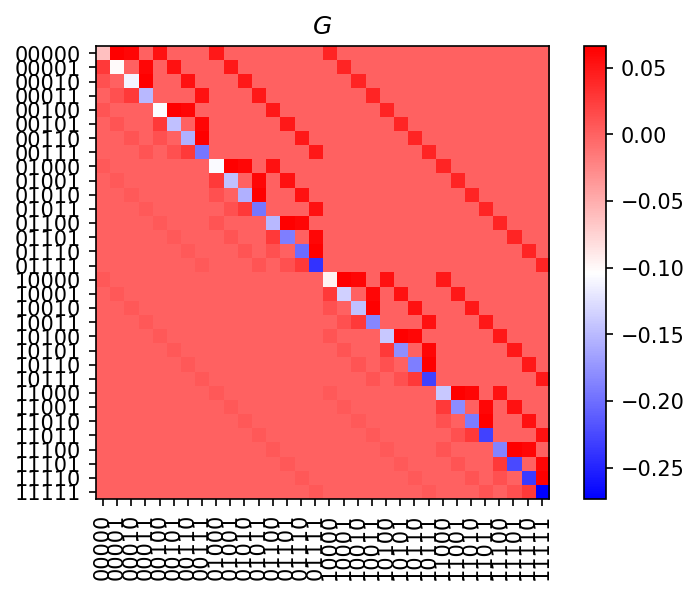

In [12]:
plt.imshow(G, cmap='bwr')
plt.colorbar()
plt.title("$G$")
plt.xticks(np.arange(0,2**num_qubits,1), [format(bn, "0{:d}b".format(num_qubits)) for bn in np.arange(0,2**num_qubits,1)])
plt.yticks(np.arange(0,2**num_qubits,1), [format(bn, "0{:d}b".format(num_qubits)) for bn in np.arange(0,2**num_qubits,1)])
plt.xticks(rotation = 90)
plt.show()

Rank=32 # singular value < 1e-3=7
Inf norm=1.223, Frobenius norm=4.823, 2-Norm=1.032
Among 1024 entries, 727 entries < 1e-3, 507 entries < 1e-4, 139 entries < 1e-6


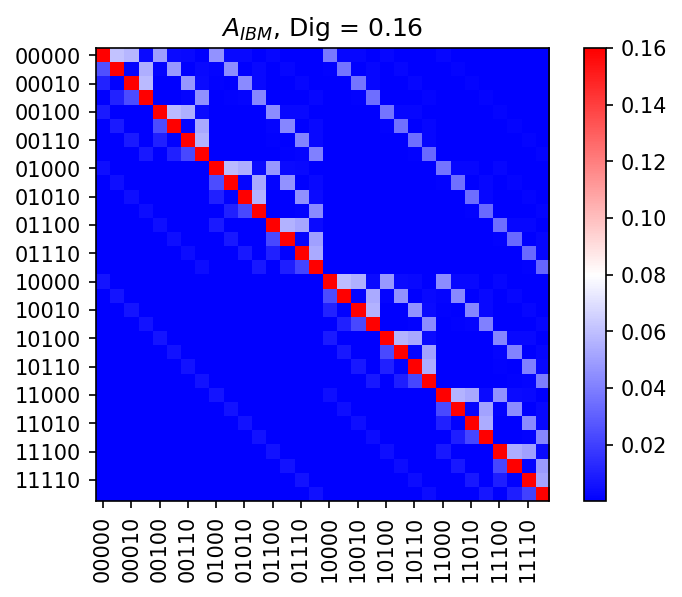

In [13]:
print_info(IBM_mat)
display_mat = IBM_mat*1
for i in range(2**num_qubits):
    display_mat[i,i] = 0.16
plt.imshow(display_mat, cmap='bwr')
plt.colorbar()
plt.title("$A_{IBM}$, Dig = 0.16")
plt.xticks(np.arange(0,2**num_qubits,2), [format(bn, "0{:d}b".format(num_qubits)) for bn in np.arange(0,2**num_qubits,2)])
plt.yticks(np.arange(0,2**num_qubits,2), [format(bn, "0{:d}b".format(num_qubits)) for bn in np.arange(0,2**num_qubits,2)])
plt.xticks(rotation = 90)
plt.show()

# Compare to the usual method

In [14]:
# Method 2
ind_data0 = {} # Given 0
ind_data1 = {} # Given 1
for q in range(len(selected_qubits)):
    ind_data0[q] = np.array([], dtype = np.int)
    ind_data1[q] = np.array([], dtype = np.int)


p0m0 = np.zeros(num_qubits) # Record probability of prepare 0 measure 0
p0m0_total = np.zeros(num_qubits) # Record number of data entries does not have correlated errors


for index in range(num_qubits):
    # Read data
    temp_string = get_basis(num_qubits, index)
    target = ''.join('1' if s == '0' else '0' for s in temp_string) # Corresponding bit string
    string_data = read_string_data(target, selected_qubits, total_qubits, file_address)
#     string_data = string_data[:int(string_data.shape[0]/4)]
    # Record number of 1's when other qubits is noise-free
    num_data = 0
    num_0 = 0
    for bits in string_data:
        others = bits[:index]+bits[index+1:] # The bits that don't include the interested qubits
        if others == '1'*(num_qubits-1): # Make sure other qubits is noise-free
            num_data += 1
            if bits[index] == '0':
                num_0 += 1
                ind_data0[index] = np.append(ind_data0[index],0)
            else:
                ind_data0[index] = np.append(ind_data0[index],1)
                
    # Record data
    p0m0[index] = num_0/num_data
    p0m0_total[index] = num_data
    
    
p1m1 = np.zeros(num_qubits) # Record probability of prepare 1 measure 1
p1m1_total = np.zeros(num_qubits) # Record number of data entries does not have correlated errors


for index in range(num_qubits):
    # Read data
    target = get_basis(num_qubits, index) # Corresponding bit string
    string_data = read_string_data(target, selected_qubits, total_qubits, file_address)
#     string_data = string_data[:int(string_data.shape[0]/4)]
    # Record number of 1's when other qubits is noise-free
    num_data = 0
    num_1 = 0
    for bits in string_data:
        others = bits[:index]+bits[index+1:] # The bits that don't include the interested qubits
        if others == '0'*(num_qubits-1): # Make sure other qubits is noise-free
            num_data += 1
            if bits[index] == '1':
                num_1 += 1
                ind_data1[index] = np.append(ind_data1[index],1)
            else:
                ind_data1[index] = np.append(ind_data1[index],0)
                
    # Record data
    p1m1[index] = num_1/num_data
    p1m1_total[index] = num_data

In [15]:
std_erros0 = np.array([],dtype = np.float64)
std_erros1 = np.array([],dtype = np.float64)
for i in range(len(selected_qubits)):
    std_erros0 = np.append(std_erros0, np.std(ind_data0[i])/np.sqrt(p0m0_total[i]))
    std_erros1 = np.append(std_erros1, np.std(ind_data1[i])/np.sqrt(p1m1_total[i]))

for i in range(len(selected_qubits)):
    print("Qubit {:d}: sd(0|0)={:8.4g}, sd/sqrt(N)={:8.3e}| sd(1|1)={:8.4g}, sd/sqrt(N)={:8.3e}"
          .format(selected_qubits[i], 
                  np.std(ind_data0[i]),
                  np.std(ind_data0[i])/np.sqrt(p0m0_total[i]),
                  np.std(ind_data1[i]),
                  np.std(ind_data1[i])/np.sqrt(p1m1_total[i])))

Qubit 0: sd(0|0)= 0.08096, sd/sqrt(N)=3.546e-04| sd(1|1)=  0.1964, sd/sqrt(N)=7.882e-04
Qubit 1: sd(0|0)=  0.0609, sd/sqrt(N)=2.661e-04| sd(1|1)=  0.2133, sd/sqrt(N)=8.568e-04
Qubit 2: sd(0|0)= 0.09144, sd/sqrt(N)=3.990e-04| sd(1|1)=   0.222, sd/sqrt(N)=8.874e-04
Qubit 3: sd(0|0)= 0.09182, sd/sqrt(N)=3.982e-04| sd(1|1)=  0.2383, sd/sqrt(N)=9.526e-04
Qubit 4: sd(0|0)=  0.1618, sd/sqrt(N)=7.005e-04| sd(1|1)=  0.2427, sd/sqrt(N)=9.609e-04


In [16]:
# Create Matrix
# matrix with independent assumption
c = 2 # multiplier
highest_single_mats = qubit_matrix(p0m0-c*std_erros0,p1m1-c*std_erros1)
lowest_single_mats = qubit_matrix(p0m0+c*std_erros0,p1m1+c*std_erros1)
single_qubit_mats = qubit_matrix(p0m0,p1m1)

# matrix with independent assumption
ind_mat = single_qubit_mats[0]
hig_ind = highest_single_mats[0]
low_ind = lowest_single_mats[0]
for i in range(1,num_qubits):
    ind_mat = np.kron(ind_mat, single_qubit_mats[i])
    hig_ind = np.kron(hig_ind, highest_single_mats[i])
    low_ind = np.kron(low_ind, lowest_single_mats[i])
    
corr_coords = []
for i in range(2**num_qubits):
    for j in range(2**num_qubits):
        # Find left(lower bound) and right(upper bound)
        if low_ind[i,j] <= hig_ind[i,j]:
            left = low_ind[i,j]
            right = hig_ind[i,j]
        else:
            left = hig_ind[i,j]
            right = low_ind[i,j]
        # See if each entry is in the range
        if mean_mat[i,j] > right or mean_mat[i,j] < left: # If below lower bound or above the upperbound
            corr_coords.append((i,j))

Rank=32 # singular value < 1e-3=8
Inf norm=1.227, Frobenius norm=4.839, 2-Norm=1.034
Among 1024 entries, 724 entries < 1e-3, 532 entries < 1e-4, 187 entries < 1e-6


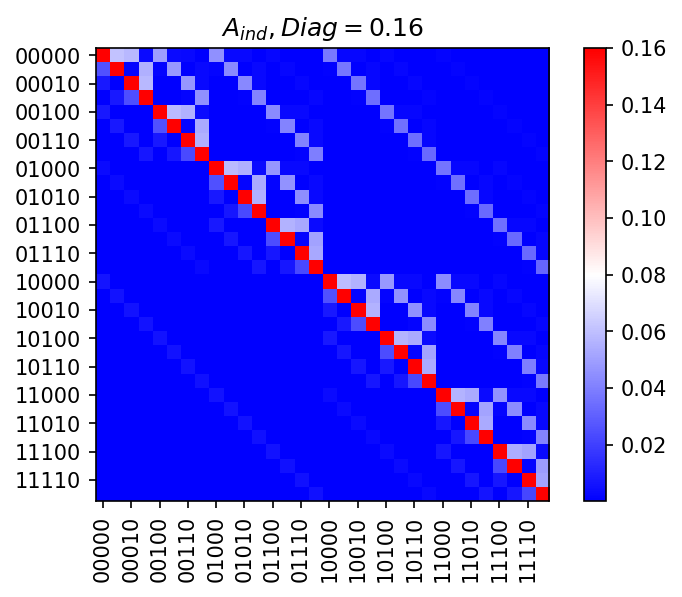

In [22]:
print_info(ind_mat)
display_mat = ind_mat*1
for i in range(2**num_qubits):
    display_mat[i,i] = 0.16
plt.imshow(display_mat, cmap='bwr')
plt.colorbar()
plt.title("$A_{ind}, Diag=0.16$")
plt.xticks(np.arange(0,2**num_qubits,coor_intv), [format(bn, "0{:d}b".format(num_qubits)) for bn in np.arange(0,2**num_qubits,coor_intv)])
plt.yticks(np.arange(0,2**num_qubits,coor_intv), [format(bn, "0{:d}b".format(num_qubits)) for bn in np.arange(0,2**num_qubits,coor_intv)])
plt.xticks(rotation = 90)
plt.show()

Rank=31 # singular value < 1e-3=0
Inf norm=0.01527, Frobenius norm=0.02253, 2-Norm=0.008683
Among 1024 entries, 948 entries < 1e-3, 751 entries < 1e-4, 192 entries < 1e-6


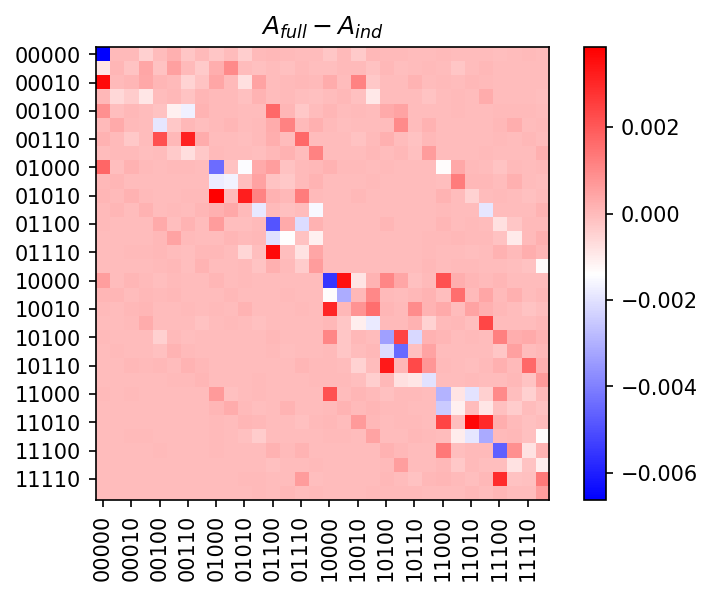

In [18]:
# Differences
diff_mat = mean_mat - ind_mat
print_info(diff_mat)

plt.imshow(diff_mat, cmap='bwr')
plt.colorbar()
plt.title("$A_{full} - A_{ind}$")
plt.xticks(np.arange(0,2**num_qubits,coor_intv), [format(bn, "0{:d}b".format(num_qubits)) for bn in np.arange(0,2**num_qubits,coor_intv)])
plt.yticks(np.arange(0,2**num_qubits,coor_intv), [format(bn, "0{:d}b".format(num_qubits)) for bn in np.arange(0,2**num_qubits,coor_intv)])
plt.xticks(rotation = 90)
plt.show()

Rank=32 # singular value < 1e-3=0
Inf norm=0.01228, Frobenius norm=0.01698, 2-Norm=0.007994
Among 1024 entries, 980 entries < 1e-3, 884 entries < 1e-4, 471 entries < 1e-6


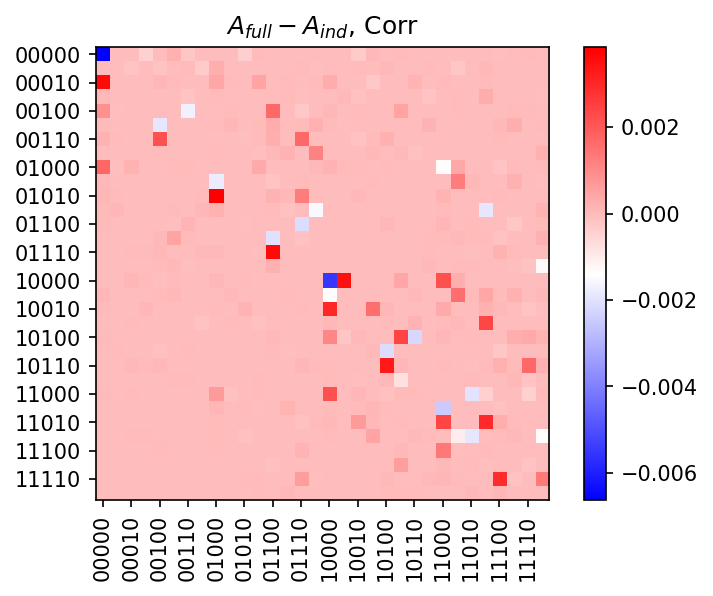

In [19]:
# Differences
diff_mat = mean_mat - ind_mat
for i in range(2**num_qubits):
    for j in range(2**num_qubits):
        if (i,j) not in corr_coords:
            diff_mat[i,j] = 0
print_info(diff_mat)

plt.imshow(diff_mat, cmap='bwr') #,vmin = -0.003, vmax = 0.005 
plt.colorbar()
plt.title("$A_{full} - A_{ind}$, Corr")
plt.xticks(np.arange(0,2**num_qubits,coor_intv), [format(bn, "0{:d}b".format(num_qubits)) for bn in np.arange(0,2**num_qubits,coor_intv)])
plt.yticks(np.arange(0,2**num_qubits,coor_intv), [format(bn, "0{:d}b".format(num_qubits)) for bn in np.arange(0,2**num_qubits,coor_intv)])
plt.xticks(rotation = 90)
plt.show()

Rank=31 # singular value < 1e-3=0
Inf norm=0.01022, Frobenius norm=0.02041, 2-Norm=0.007108
Among 1024 entries, 948 entries < 1e-3, 709 entries < 1e-4, 151 entries < 1e-6


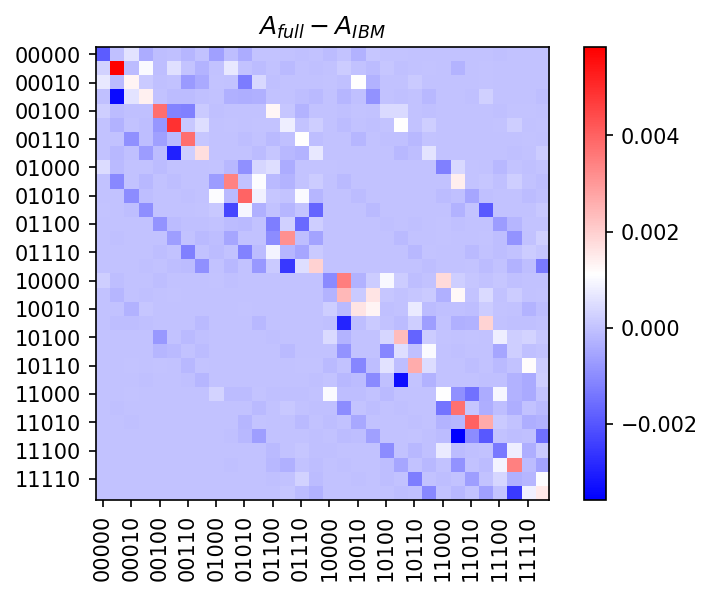

In [20]:
# Differences
diff_mat = mean_mat - IBM_mat
print_info(diff_mat)

plt.imshow(diff_mat, cmap='bwr')
plt.colorbar()
plt.title("$A_{full} - A_{IBM}$")
plt.xticks(np.arange(0,2**num_qubits,coor_intv), [format(bn, "0{:d}b".format(num_qubits)) for bn in np.arange(0,2**num_qubits,coor_intv)])
plt.yticks(np.arange(0,2**num_qubits,coor_intv), [format(bn, "0{:d}b".format(num_qubits)) for bn in np.arange(0,2**num_qubits,coor_intv)])
plt.xticks(rotation = 90)
plt.show()

Rank=32 # singular value < 1e-3=0
Inf norm=0.007281, Frobenius norm=0.01063, 2-Norm=0.004556
Among 1024 entries, 993 entries < 1e-3, 883 entries < 1e-4, 441 entries < 1e-6


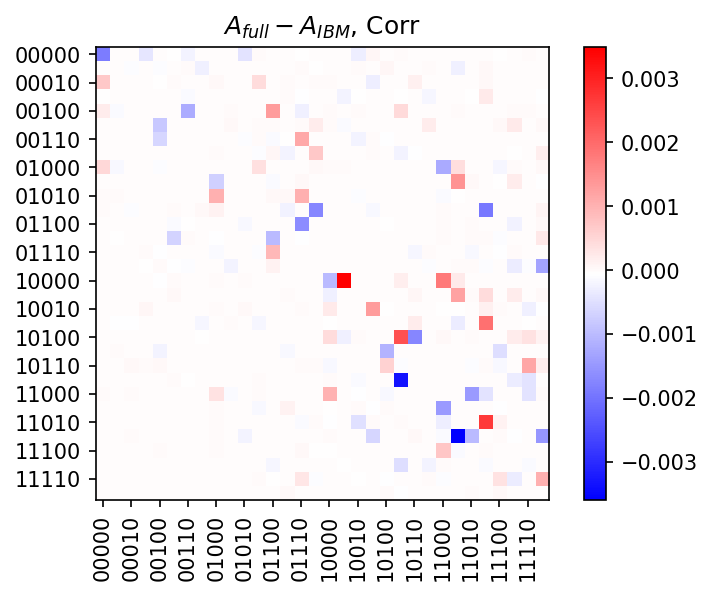

In [21]:
# Differences
diff_mat = mean_mat - IBM_mat
for i in range(2**num_qubits):
    for j in range(2**num_qubits):
        if (i,j) not in corr_coords:
            diff_mat[i,j] = 0
print_info(diff_mat)

plt.imshow(diff_mat, cmap='bwr') #,vmin = -0.003, vmax = 0.005 
plt.colorbar()
plt.title("$A_{full} - A_{IBM}$, Corr")
plt.xticks(np.arange(0,2**num_qubits,coor_intv), [format(bn, "0{:d}b".format(num_qubits)) for bn in np.arange(0,2**num_qubits,coor_intv)])
plt.yticks(np.arange(0,2**num_qubits,coor_intv), [format(bn, "0{:d}b".format(num_qubits)) for bn in np.arange(0,2**num_qubits,coor_intv)])
plt.xticks(rotation = 90)
plt.show()